In [201]:
#!/usr/bin/env python
# coding: utf-8

# # load dataset

# In[1]:
import os, sys
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
print(f"sys.path.append(parent_dir): {parent_dir}")
sys.path.append(parent_dir)

from utils.load_h5 import Dataset4h5, ranges_dict
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerBase

import numpy as np
from torch.utils.data import DataLoader
import h5py
import matplotlib as mpl
from scipy.fftpack import fft, fftshift, ifft
from scipy.fftpack import fftfreq
from scipy.linalg import sqrtm
# print("before torch")
import torch
# print("after torch")
from matplotlib.lines import Line2D
from kymatio.torch import Scattering2D

from scipy.interpolate import interp1d
import joblib
from tqdm import tqdm
import gc
# print("before summary writer")
# from torch.utils.tensorboard import SummaryWriter
# print("after summary writer")
import multiprocessing
import matplotlib.ticker as ticker
from numpy import interp
from matplotlib.ticker import FuncFormatter
import matplotlib
from typing import List
import argparse

import os

# print("before spawn")
multiprocessing.set_start_method('spawn', force=True)
# print("after spawn")

#ranges_dict = dict(
#    params = {
#        0: [4, 6], # ION_Tvir_MIN
#        1: [10, 250], # HII_EFF_FACTOR
#        },
#    images = {
#        0: [-387, 86], # brightness_temp
#        # 0: [-338, 54], # brightness_temp
#        }
#    )

sys.path.append(parent_dir): /pscratch/sd/b/binxia/ml21cm


In [202]:
# In[2]:

def load_h5_as_tensor(dir_name='LEN128-DIM64-CUB8.h5', num_image=256, num_redshift=1024, HII_DIM=64, z_step=1, scale_path=False, dim=3, startat=0, pt_fname=None, transform=False):
    dir_name = os.path.join(os.environ['SCRATCH'], dir_name)
    dataset = Dataset4h5(dir_name, num_image=num_image, num_redshift=num_redshift, HII_DIM=HII_DIM, z_step=z_step, scale_path=scale_path, dim=dim, startat=startat)

    with h5py.File(dir_name) as f:
        los = f['redshifts_distances'][:,startat:startat+dataset.num_redshift]

    dataloader = DataLoader(dataset, batch_size=800)
    
    x, c = next(iter(dataloader))

    if 'sim' in transform and (pt_fname is not None):
        original_shape = x.shape
        pt = joblib.load(pt_fname)
        x = pt.transform(x.reshape(-1, 1))#original_shape[-1]))
        x = torch.from_numpy(x.reshape(*original_shape))

    return x, c, los


# In[3]:

os.environ["SLURM_NODEID"] = '0'

In [203]:
def get_eor_cmap(vmin=-150, vmax=30):
    name = f"EoR-{vmin}-{vmax}"
    negative_segments = 4
    positive_segments = 2
    neg_frac = abs(vmin) / (vmax - vmin)
    neg_seg_size = neg_frac / negative_segments
    pos_frac = abs(vmax) / (vmax - vmin)
    pos_seg_size = pos_frac / positive_segments

    EoR_colour = matplotlib.colors.LinearSegmentedColormap.from_list(
        name,
        [
            (0, 'white'),
            (0.33, 'yellow'),
            (0.5, 'orange'),
            (0.68, 'red'),
            (0.83333333, 'black'),
            (0.9, 'blue'),
            (1, 'cyan')])
    
    try:
        matplotlib.colormaps.register(cmap=EoR_colour)
    except ValueError:
        matplotlib.colormaps.unregister(name)
        matplotlib.colormaps.register(cmap=EoR_colour)

    return name

vmin = -150#Tb_all.min()
vmax = 30#Tb_all.max()
# print(vmin, vmax)
cmap = get_eor_cmap(vmin, vmax)

def calc_ps(field, L):
    ng = field.shape[0]
    ru = np.fft.fftn(field)
    
    ru *= (L/ng)**field.ndim

    if field.ndim == 3:
        ru = ru[0:ng//2+1, 0:ng//2+1, 0:ng//2+1]
    elif field.ndim ==2:
        ru = ru[0:ng//2+1, 0:ng//2+1]

    # ru *= (2/ng)**field.ndim
    ru = np.abs(ru)**2

    kx = np.fft.rfftfreq(ng) * ng / L
    ky = kx.copy()
    kz = kx.copy()

    kmin = 1/L
    kmax = 0.5*ng/L
    
    kbins = np.arange(kmin, kmax, kmin)
    Nk = len(kbins)
    
    if field.ndim == 3:
        k_nd = np.meshgrid(kx, ky, kz, indexing="ij")
        # print("field.ndim == 3:")
    elif field.ndim == 2:
        k_nd = np.meshgrid(kx, ky, indexing="ij")
        # print("field.ndim == 2:")
    
    k = np.sqrt(np.sum(np.array(k_nd)**2,axis=0))

    # hist, edges = np.histogram(k, weights=ru, bins=Nk)
    # Pk = ng * hist / kbins**(field.ndim - 1)
    
    Pk = np.array([np.mean(ru[(k >= kbins[i]) & (k < kbins[i+1])]) for i in range(len(kbins)-1)])
    kbins = (kbins[:-1] + kbins[1:])/2

    if field.ndim == 3:
        Pk *= (kbins**3) / (2*np.pi**2)
    elif field.ndim == 2:
        Pk *= (kbins**2) / (2*np.pi)

    return kbins, Pk

def x2Pk(x, z_idx=0):
    print(f"x2Pk, x.shape = {x.shape}")
    Pk_vals_all = []
    for i in range(x.shape[0]):
        if x.ndim == 4:
            # density_field = x[i,0]
            density_field = x[i,0,:,z_idx:z_idx+64]
        elif x.ndim == 5:
            # density_field = x[i,0]
            density_field = x[i,0,...,z_idx]
            # density_field = x[i,0,:,0,z_idx:z_idx+64]
        if density_field.ndim == 3:
            Nx, Ny, Nz = density_field.shape
            box_size = 128#(128.0, 128.0, 1024.0) #512#
        elif density_field.ndim == 2:
            Nx, Ny = density_field.shape
            box_size = 128#(128.0, 1024.0) #512#

        # 计算物质功率谱
        k_vals, Pk_vals = calc_ps(density_field, box_size)
        # k_vals_all.append(k_vals)
        Pk_vals_all.append(Pk_vals)

    Pk_vals_all = np.array(Pk_vals_all)
    return k_vals, Pk_vals_all


# def rescale(x, ranges=ranges_dict['images']):
#     #x = (x + 1) / 2 * (ranges[0][1]-ranges[0][0]) + ranges[0][0]
#     x = x * ranges[0][1] + ranges[0][0]
#     return x
    
def x2Tb(x):
    #print('x.shape =', x.shape, 'x.ndim =', x.ndim)
    if x.ndim == 4:
        Tb = x[:,0].mean(axis=1)
    elif x.ndim == 5:
        Tb = x[:,0].mean(axis=(1,2))
    return Tb

def load_x_ml(fname_pattern0, fname_pattern1, ema = 0, outputs_dir = "../training/outputs", pt_fname=None, transform=False):
    # num = 7200
    x_ml = []
    fnames = [fname for fname in os.listdir(outputs_dir) if fname_pattern0 in fname and fname_pattern1 in fname and f'-ema{ema}' in fname]
    if len(fnames) == 0:
        raise ValueError(f"No files found with patterns: {fname_pattern0}, {fname_pattern1} in {outputs_dir}")
    else:
        print("fname pattern:", fname_pattern0, fname_pattern1, "; len(fnames) =", len(fnames), ";\nfnames[0] =", fnames[0])

    for fname in fnames:
    #    if ema and 'ema1' not in fname:
    #        continue
    #    if not ema and 'ema1' in fname:
    #        continue
        data = np.load(os.path.join(outputs_dir, fname))
        # print(fname)
        x_ml.append(data)

    x_ml = np.concatenate(x_ml, axis=0)
    original_shape = x_ml.shape

    if 'ml' in transform and (pt_fname is not None):
        pt = joblib.load(pt_fname)
        x_ml = pt.inverse_transform(x_ml.reshape(-1, 1))#original_shape[-1]))

    x_ml = torch.from_numpy(x_ml.reshape(*original_shape))
    print(f"loaded x_ml.shape = {x_ml.shape}")
    return x_ml


# === 自定义 handler：让矩形和虚线重叠显示 ===
class HandlerRectLine(HandlerBase):
    def create_artists(self, legend, orig_handle, x0, y0, width, height, fontsize, trans):
        # 画矩形
        rect = Rectangle((x0, y0), width, height,
                         facecolor=orig_handle.get('rect_fc', 'black'),
                         edgecolor=orig_handle.get('rect_ec', 'black'),
                         alpha=orig_handle.get('rect_alpha', 0.3),
                         transform=trans)
        # 画中间的虚线
        line = Line2D([x0, x0 + width], [y0 + height/2, y0 + height/2],
                      color=orig_handle.get('line_color', 'black'),
                      linestyle=orig_handle.get('line_ls', ':'),
                      linewidth=orig_handle.get('line_lw', 1.5),
                      transform=trans)
        return [rect, line]

In [204]:
def plot_global_signal(x_pairs, params, los, sigma_level=68.27, alpha=0.2, lw = 0.6, y_eps = 0, savename=None):
    low = (100 - sigma_level) / 2
    high = 100 - low
    fig, ax = plt.subplots(4,1, sharex=True, figsize=(8,6), dpi=100, gridspec_kw={'height_ratios': [1.5,.5,.5,.5]})
    
    for i, (x0, x1) in enumerate(x_pairs):
        # print(Tb0.shape)
        interval = x0.shape[-1] // 100

        Tb0 = x2Tb(x0)
        Tb1 = x2Tb(x1)
        
        y0 = np.median(Tb0, axis=0)
        y1 = np.median(Tb1, axis=0)

        Tb0_perc = np.percentile(Tb0, [low, high], axis=0)
        ax[0].fill_between(los[1,:Tb0_perc.shape[-1]], Tb0_perc[0], Tb0_perc[1], alpha=alpha, facecolor=f"C{i}", edgecolor='black')
        # ax[0].plot(los[1], Tb0[:4].T, lw=0.5)
        Tb1_perc = np.percentile(Tb1, [low, high], axis=0)
        yerr_lower = y1 - Tb1_perc[0]
        yerr_upper = Tb1_perc[1] - y1
        ax[0].errorbar(los[1,:Tb0_perc.shape[-1]][::interval], y1[::interval], yerr=[yerr_lower[::interval], yerr_upper[::interval]], linestyle='-', c=f"C{i}", marker='|', markersize=1, linewidth=lw)#, label='diffusion')

        ax[0].plot(los[1,:Tb0_perc.shape[-1]], y0, linestyle=':', c=f"C{i}", lw=3*lw)
        #print(f"⚠️ {i=}; {Tb0_perc.shape[-1]=}; {y0.shape=}; {y1.shape=}; {y0[-1]=}; {y1[-1]=}; {np.isnan(y0).sum()=}; {np.isnan(y1).sum()=}")
        ax[1].plot(los[1,:Tb0_perc.shape[-1]][abs(y0)>y_eps], ((y1-y0)/abs(y0))[abs(y0)>y_eps], label=f'{np.array(params[i])}', c=f"C{i}", lw=lw)

        sigma0 = 0.5*(Tb0_perc[1]-Tb0_perc[0])
        sigma1 = 0.5*(Tb1_perc[1]-Tb1_perc[0])
        ax[2].plot(los[1,:Tb0_perc.shape[-1]][sigma0>1.5*y_eps], ((y1-y0)/sigma0)[sigma0>1.5*y_eps], label=f'{np.array(params[i])}', c=f"C{i}", lw=lw)
        
        ax[3].plot(los[1,:Tb0_perc.shape[-1]][sigma0>1.5*y_eps], (sigma1/sigma0-1)[sigma0>1.5*y_eps], c=f"C{i}", lw=lw)

    #ax[0].set_yscale('symlog')
    ax[0].set_ylabel(r'$\langle T_b \rangle$ [mK]')
    ax[0].grid()

    # === 你已有的 legend 准备部分 ===
    ax1_handles, ax1_labels = ax[1].get_legend_handles_labels()

    legend_line2 = Line2D([0], [0], linestyle='-', color='black', marker='|', markersize=8)

    # 这里用 dict 来定义“矩形+虚线”组合
    legend_handle_rectline = {
        'rect_fc': 'black',
        'rect_ec': 'black',
        'rect_alpha': alpha,    # 你原来的透明度参数
        'line_color': 'black',
        'line_ls': ':',
    }

    legend_elements = [
        legend_handle_rectline,   # 会被 HandlerRectLine 处理，绘制叠加图例
        legend_line2
    ]

    legend_labels = ['21cmfast', 'diffusion']

    # === 添加图例 ===
    ax[0].legend(
        legend_elements + ax1_handles,
        legend_labels + ax1_labels,
        handler_map={dict: HandlerRectLine()},  # 替代原来的 tuple handler
        fontsize=8,
    )

    ax[1].set_ylabel(r"$\epsilon_{rel}$")
    # ax[1].set_yscale("symlog", linthresh=0.1)
    ax[1].set_ylim(-1.99,1.99)
    ax[2].set_ylim(-1.99,1.99)
    ax[3].set_ylim(-1.99,1.99)

    ax[1].grid()
    
    # ax1_sec = ax[1].secondary_xaxis('top')
    # ax1_sec.set_xticklabels([])

    ax[2].set_ylabel(r"$\epsilon_{std}$")
    
    ax[3].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x / 1000:.1f}'))
    ax[3].set_xlabel('distance [Gpc]')
    ax[2].grid()
    ax[3].grid()
    
    ax[3].set_ylabel(r"$\epsilon_{\sigma}$")
    
    ax_twin = ax[0].secondary_xaxis('top')               # 创建共享 y 轴的第二个 x 轴
    ax_twin.set_xlim(ax[0].get_xlim())       # 设置副 x 轴的范围与主 x 轴相同
    ax_twin.set_xlabel('redshift')           # 设置副 x 轴标签
    ax_twin.xaxis.set_major_locator(ticker.MaxNLocator(10))  # 这里5表示最多显示5个刻度
    ax_twin.set_xticks(ax_twin.get_xticks())                  # 设置刻度为 z 的值
    z_ticks = interp(ax_twin.get_xticks(), los[1], los[0])
    ax_twin.set_xticklabels([f"{ztick:.1f}" for ztick in z_ticks])
    ax_twin.spines['bottom'].set_position(('outward', 10))  # 将副 x 轴向外移动 40 像素
    
    for axis in ax:
        axis.tick_params(axis='y', labelsize=10)  # 设置所有子图的 y 轴刻度标签字体大小为 8

    plt.subplots_adjust(hspace=0)
    if savename == None:
        plt.show()
    else:
        savename = f"global_Tb_{savename}.pdf"
        plt.savefig(savename, bbox_inches='tight',)
        print(f'Image saved to {savename}')


# In[35]:

In [205]:
def plot_power_spectrum(x_pairs, params, los, sigma_level=68.27, alpha=0.2, z_idx=0, savename=None):
    low = (100 - sigma_level) / 2
    high = 100 - low
    fig, ax = plt.subplots(4,1, sharex=True, figsize=(8,6), dpi=100, gridspec_kw={'height_ratios': [1.5,.5,.5,.5]})
    
    for i, (x0, x1) in enumerate(x_pairs):
        k_vals, Pk0 = x2Pk(x0, z_idx=z_idx)
        k_vals, Pk1 = x2Pk(x1, z_idx=z_idx)
        y0 = np.median(Pk0, axis=0)
        y1 = np.median(Pk1, axis=0)
        
        Pk0_perc = np.percentile(Pk0, [low, high], axis=0)
        ax[0].fill_between(k_vals, Pk0_perc[0], Pk0_perc[1], alpha=alpha, facecolor=f"C{i}", edgecolor='black')

        ax[0].plot(k_vals, y0, linestyle=':', c=f"C{i}")#, label='sim')

        Pk1_perc = np.percentile(Pk1, [low, high], axis=0)
        yerr_lower = y1 - Pk1_perc[0]
        yerr_upper = Pk1_perc[1] - y1
        ax[0].errorbar(k_vals, y1, yerr=[yerr_lower, yerr_upper], linestyle='-', c=f"C{i}", marker='|', markersize=1, linewidth=1)#, label='diffusion')
        
        ax[1].plot(k_vals, (y1-y0)/y0, label=f'{np.array(params[i])}', c=f"C{i}")

        sigma0 = 0.5*(Pk0_perc[1]-Pk0_perc[0])
        # if np.any(sigma0 == 0):
        #     print(f"🆘 Warning: sigma0 has zero values for params {params[i]}, skipping those k values in epsilon_std plot for PT.")
        #     sigma0 = np.where(sigma0 == 0, 1e-4, sigma0)  # 替换为一个很小的数，避免除以零
        sigma1 = 0.5*(Pk1_perc[1]-Pk1_perc[0])
        ax[2].plot(k_vals, (y1-y0)/sigma0, label=f'{np.array(params[i])}', c=f"C{i}")
        ax[3].plot(k_vals, sigma1/sigma0-1, c=f"C{i}")

    ax[0].set_xscale('log')
    # ax[0].set_ylim(0,10**5)
    ax[0].set_yscale('log')
    ax[0].set_ylim(1.1e-1,10**5)

    ax[0].set_ylabel(r'$\Delta^2(k)$ [mK$^2$]')
    ax[0].grid()
    
    ax[1].set_ylim(-1.99,1.99)
    ax[2].set_ylim(-1.99,1.99)
    ax[3].set_ylim(-1.99,1.99)

    # legend_line1 = Line2D([0], [0], linestyle=':', color='black')
    # legend_line2 = Line2D([0], [0], linestyle='-', color='black', marker='|', markersize=10)

    # # 创建自定义图例条目
    # legend_elements = [
    #     (Patch(facecolor='black', edgecolor='black', alpha=alpha),legend_line1), 
    #     (legend_line2),
    # ]
    # 添加自定义图例
    # ax[0].legend(legend_elements, ['21cmfast', 'diffusion'], handler_map={tuple: HandlerTuple(ndivide=None)})

    ax[0].set_title(r"power spectrum of $T_b$ at z = "+f"{los[0][z_idx]:.2f}")
        # plt.xlim(xmin=0.01)
        # ax[0].legend()

    ax[1].set_xscale('log')
        # ax[1].hlines(0,0.01,0.3)
        # ax[1].hlines(0.1,0.01,0.3)
        # ax[1].hlines(-0.1,0.01,0.3)
    ax[1].set_ylabel(r"$\epsilon_{rel}$")
    # ax[1].set_xlabel('k [Mpc$^{-1}$]')
    ax[1].grid()
    ax1_sec = ax[1].secondary_xaxis('top')
    ax1_sec.set_xticklabels([])
    # ax[1].legend()

    ax[2].set_xscale('log')
    ax[2].set_ylabel(r"$\epsilon_{std}$")
    # ax[3].set_xlabel('k [Mpc$^{-1}$]')
    ax[2].grid()
    ax2_sec = ax[2].secondary_xaxis('top')
    ax2_sec.set_xticklabels([])

    ax[3].set_xscale('log')
    ax[3].set_ylabel(r"$\epsilon_{\sigma}$")
    ax[3].set_xlabel('k [Mpc$^{-1}$]')
    ax[3].grid()
    ax3_sec = ax[3].secondary_xaxis('top')
    ax3_sec.set_xticklabels([])

    plt.subplots_adjust(hspace=0)

    if savename == None:
        plt.show()
    else:
        savename = f"power_spectrum_{savename}_{z_idx}.pdf"
        plt.savefig(savename, bbox_inches='tight',)
        print(f'Image saved to {savename}')

In [206]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def sort_S2_by_l(S2, jthetas, L):
    # print("S2.shape =", S2.shape)
    S2_sorted = np.empty((L, S2.shape[0], S2.shape[1]//L))
    jthetas_sorted = np.empty((L, S2.shape[1]//L, 2, 2))
    # jthetas_sorted = [[]]*L
    num_updated = np.zeros(L, dtype=int)

    # print("jthetas =", jthetas)
    for i, jtheta in enumerate(jthetas):
        index = (jtheta[1][1]-jtheta[1][0]) % L
        # print("index =", index)
        # print("num_updated =", num_updated)
        S2_sorted[index, :, num_updated[index]] = S2[:,i]
        # print("sort_S2_by_l", jthetas_sorted[index*L+num_updated[index]], np.array(jtheta))
        jthetas_sorted[index, num_updated[index]][0] = jtheta[0]
        jthetas_sorted[index, num_updated[index]][1] = jtheta[1]
        # print("S2_sorted[:, index*L+num_updated[index]] =", S2_sorted[:, index*L+num_updated[index]])
        # jthetas_sorted[index] = jtheta
        # print("jtheta =", jtheta)
        # print("jthetas_sorted.shape =", jthetas_sorted.shape)
        # print("left =", jthetas_sorted[index*L+num_updated[index],:])
        # print("right =", np.array(jtheta))
        # jthetas_sorted[index*L+num_updated[index],:] = np.array(jtheta)
        # print("index, S2_sorted.shape =", index, np.shape(S2_sorted))
        num_updated[index] += 1
    # print("index*L+num_updated[index]", index*L+num_updated[index])
    # print("i =", i)
    # print("sort_S2_by_l, num_updated =", num_updated)

    S2_sorted = np.array(S2_sorted)
    # print("S2_sorted.shape", S2_sorted.shape)
    # print("S2_sorted", S2_sorted)
    jthetas_sorted = np.array(jthetas_sorted)
    # print('sort_S2_by_l S2_sorted.shape',S2_sorted.shape)
    # print('sort_S2_by_l jthetas_sorted.shape', jthetas_sorted.shape)
    return S2_sorted, jthetas_sorted


def calculate_sorted_S2(x, S, J, L, jthetas):
    x = x.to(S.filters[0].dtype) if hasattr(S, 'filters') else x.to(torch.float32)
    S_all = np.mean(S(x.to(device))[:,0].cpu().numpy(), axis=(2,3))

    ############################################################
    for j1 in range(J-1):
        for j2 in range(j1+1, J):
            # if j2>j1:
            # print("j1", j1, "j2", j2)
            index = [jtheta[0] == (j1,j2) for jtheta in jthetas]
            # print(index)
            # print(jthetas[index])
            # cache = S2[:,index]
            # print(index)
            if (j1,j2) == (0,1):
                S2 = S_all[:,index]
                jthetas_2 = np.array(jthetas[index])
                # index_reduced = index
            else:
                S2 = np.concatenate((S2, S_all[:,index]), axis = 1)
                jthetas_2 = np.concatenate([jthetas_2, np.array(jthetas[index])], axis = 0)

    S2_sorted, jthetas_sorted = sort_S2_by_l(S2, jthetas_2, L)
    # print(index_reduced.shape)
    return S2_sorted, jthetas_sorted

def calculate_reduced_S2(x_pairs, params, J=5, L=4, M=64, N=64, z_idx=0):
    S2_reduced_list = []
    jthetas_reduced_list = []
    for i, (x0, x1) in enumerate(x_pairs):
        #print(f"#{i}: x0.shape = {x0.shape}, x1.shape = {x1.shape}")
        # get jthetas and S
        # z_idx=x0.shape[-1]//2 - 32
        if x0.ndim == 4:
            x0 = x0[...,z_idx:z_idx+64]
            x1 = x1[...,z_idx:z_idx+64]
        elif x0.ndim == 5:
            x0 = x0[...,z_idx]
            x1 = x1[...,z_idx]

        if i == 0:
            S = Scattering2D(J, (M, N), L=L, out_type='list').to(device)
            jthetas = []
            x0 = x0.to(S.filters[0].dtype) if hasattr(S, 'filters') else x0.to(torch.float32)
            for dicts in S(x0.to(device, dtype=S.filters[0].dtype if hasattr(S, 'filters') else torch.float32)):
                jthetas.append([dicts['j'], dicts['theta']])

            jthetas = np.array(jthetas, dtype=object)
            S = Scattering2D(J, (M, N), L=L).to(device)
            
        S2_reduced_0, jthetas_reduced_0 = calculate_sorted_S2(x0, S, J, L, jthetas)
        S2_reduced_1, jthetas_reduced_1 = calculate_sorted_S2(x1, S, J, L, jthetas)
        # print("S2_reduced.shape =", S2_reduced.shape)
        S2_reduced_list.append((S2_reduced_0, S2_reduced_1))
        jthetas_reduced_list.append((jthetas_reduced_0, jthetas_reduced_1))

    return S2_reduced_list, jthetas_reduced_list


# In[44]:


def average_single_S2_over_l(S2, jthetas, L=4):
    # print("average_single_S2_over_l, shape =", S2.shape, jthetas.shape)
    S2_reshape = np.array(np.array_split(S2, S2.shape[2]//L, axis=2))
    # jthetas_reshape = jthetas.reshape(jthetas.shape[0],jthetas.shape[1]//L, L,jthetas.shape[2],jthetas.shape[3])
    jthetas_reshape = np.array(np.array_split(jthetas, jthetas.shape[1]//L, axis=1))
    # print("average_single_S2_over_l, shape =", S2_reshape.shape, jthetas_reshape.shape)
    # print("---"*30)
    # print(jthetas_reshape[0])
    # print("---"*30)
    S2_average = np.average(S2_reshape, axis=3)
    # jthetas_average = np.average(jthetas_reshape, axis=2)
    jthetas_average = jthetas_reshape[:,:,0,0,:]
    # print(S2_average.shape, jthetas_average.shape)
    # print(jthetas_average)
    # print("---"*30)
    S2_transpose = S2_average.transpose(2,1,0)
    # print(S2_transpose.shape)
    # print("---"*30)
    S2_combine = S2_transpose.reshape(S2_transpose.shape[0], -1)
    # print(S2_combine.shape)
    # print("---"*30)
    j1j2 = jthetas_average.transpose(1,0,2).reshape(-1, 2)
    # j1j2 = np.tile(jthetas_average, (S2_combine.shape[1]//jthetas_average.shape[0],1))
        # S2_average.append(())
    return S2_combine, j1j2.astype(int)

def average_S2_over_l(x_pairs, params, J, L, M, N, z_idx=0):

    S2_list, jthetas_list = calculate_reduced_S2(x_pairs, params, J, L, M, N, z_idx)

    S2_average = []
    j1j2_average = []
    for i in range(len(S2_list)):
        S2_sim = S2_list[i][0]
        jthetas_sim = jthetas_list[i][0]
        S2_combine_sim, j1j2_sim = average_single_S2_over_l(S2_sim, jthetas_sim, L)

        S2_ml = S2_list[i][1]
        jthetas_ml = jthetas_list[i][1]
        S2_combine_ml, j1j2_ml = average_single_S2_over_l(S2_ml, jthetas_ml, L)

        S2_average.append((S2_combine_sim, S2_combine_ml))
        j1j2_average.append((j1j2_sim, j1j2_ml))
    return np.array(S2_average), np.array(j1j2_average)

# In[46]:


def plot_scattering_transform_2(x_pairs, params, los, sigma_level=68.27, alpha=0.2, J=5, L=4, M=64, N=64, savename=None, z_idx=0):
    low = (100 - sigma_level) / 2
    high = 100 - low
    S2, j1j2 = average_S2_over_l(x_pairs, params, J, L, M, N, z_idx)
    fig, ax = plt.subplots(4,1, sharex=True, figsize=(12,6), dpi=100, gridspec_kw={'height_ratios': [1.5,.5,.5,.5]})
    ax[0].set_title(f"reduced scattering coefficients at z = {los[0][z_idx]:.2f}")
    # S2 = S2[..., :20]
    #print("S2.min() =", S2.min())
    S2 = np.log10(S2)
    # j1j2 = j1j2[..., :S2.shape[3], :]
    j1j2 = j1j2[0,0]
    for i in range(len(S2)):
        S2_sim = S2[i][0]
        S2_ml = S2[i][1]

        y0 = np.median(S2_sim, axis=0)
        y1 = np.median(S2_ml, axis=0)
        # print(y0.shape)
        ax[0].plot(np.arange(y0.shape[0]), y0, lw=1, c=f"C{i}", linestyle=':')
        # plt.plot(np.median(S2_ml, axis=0), lw=1)
        S2_sim_perc = np.percentile(S2_sim, [low, high], axis=0)
        ax[0].fill_between(np.arange(S2_sim.shape[1]), S2_sim_perc[0], S2_sim_perc[1], alpha=alpha, facecolor=f"C{i}", edgecolor='black')

        S2_ml_perc = np.percentile(S2_ml, [low, high], axis=0)
        yerr_lower = y1 - S2_ml_perc[0]
        yerr_upper = S2_ml_perc[1] - y1
        ax[0].errorbar(np.arange(y1.shape[0]), y1, yerr=[yerr_lower, yerr_upper], linestyle='-', c=f"C{i}", marker='|', markersize=1, linewidth=1)#, label='diffusion')

        ax[1].plot(np.arange(y0.shape[0]), ((y1-y0)/y0), label=f'{np.array(params[i])}', c=f"C{i}")

        sigma0 = (S2_sim_perc[1]-S2_sim_perc[0])/2
        sigma1 = (S2_ml_perc[1]-S2_ml_perc[0])/2
        ax[2].plot(np.arange(y0.shape[0]), (y1-y0)/sigma0, label=f'{np.array(params[i])}', c=f"C{i}")
        ax[3].plot(np.arange(y0.shape[0]), sigma1/sigma0-1, c=f"C{i}")

    # legend_line1 = Line2D([0], [0], linestyle=':', color='black')
    # legend_line2 = Line2D([0], [0], linestyle='-', color='black', marker='|', markersize=10)

    # # 创建自定义图例条目
    # legend_elements = [
    #     (Patch(facecolor='black', edgecolor='black', alpha=alpha),legend_line1), 
    #     (legend_line2),
    # ]
    # 添加自定义图例
    # ax[0].legend(legend_elements, ['21cmfast', 'diffusion'], handler_map={tuple: HandlerTuple(ndivide=None)})

    ax[0].set_ylabel(r'$\log{S_2}$')
    ax[0].grid()
    j1j2_period = j1j2.shape[0]//L

    ax[0].set_ylim(-2.99,0)
    ax[1].set_ylim(-1.99,1.99)
    ax[2].set_ylim(-1.99,1.99)
    ax[3].set_ylim(-1.99,1.99)

    # plt.text()
    ax[0].vlines(np.arange(0-0.5, j1j2.shape[0]-0.5+j1j2_period,j1j2_period), ax[0].get_ylim()[0], ax[0].get_ylim()[1], colors='grey', alpha=0.8, linestyles=':')
    ax[1].vlines(np.arange(0-0.5, j1j2.shape[0]-0.5+j1j2_period,j1j2_period), ax[1].get_ylim()[0], ax[1].get_ylim()[1], colors='grey', alpha=0.8, linestyles=':')
    ax[2].vlines(np.arange(0-0.5, j1j2.shape[0]-0.5+j1j2_period,j1j2_period), ax[2].get_ylim()[0], ax[2].get_ylim()[1], colors='grey', alpha=0.8, linestyles=':')
    ax[3].vlines(np.arange(0-0.5, j1j2.shape[0]-0.5+j1j2_period,j1j2_period), ax[3].get_ylim()[0], ax[3].get_ylim()[1], colors='grey', alpha=0.8, linestyles=':')

    ax1_sec = ax[1].secondary_xaxis('top')
    ax1_sec.set_xticklabels([])
    # ax[1].legend()
    ax[1].grid()
    ax[1].set_ylabel(r'$\epsilon_{rel}$')

    # ax[2].set_xticks(np.arange(j1j2.shape[0]), j1j2, rotation=90)
    # ax[2].set_xlabel(r'$(j_1,\ j_2)$')
    ax[2].grid()
    # ax[2].set_ylim(ymin=-1.1)
    ax[2].set_ylabel(r'$\epsilon_{std}$')
    # print(ax[2].get_xticks())
    ax2_sec = ax[2].secondary_xaxis('top')
    ax2_sec.set_xticklabels([])
    # ax[2].set_xlim((0,19))

    ax[3].set_xticks(np.arange(j1j2.shape[0]), j1j2, rotation=90)
    ax[3].set_xlabel(r'$(j_1,\ j_2)$')
    ax[3].grid()
    # ax[2].set_ylim(ymin=-1.1)
    ax[3].set_ylabel(r'$\epsilon_{\sigma}$')
    # print(ax[2].get_xticks())
    ax3_sec = ax[3].secondary_xaxis('top')
    ax3_sec.set_xticklabels([])
    # ax[3].set_xlim((0,19))

    for i in range(L):
        if i*j1j2_period < ax[3].get_xlim()[1]:
            ax[3].text(x=i*j1j2_period, y=0.35+ax[3].get_ylim()[0], s=r"$(l_2-l_1)\%L$="+f"{i}")

    plt.subplots_adjust(hspace=0)

    if savename == None:
        plt.show()
    else:
        savename = f"scattering_coefficients_{savename}_{z_idx}.pdf"
        plt.savefig(savename, bbox_inches='tight',)
        print(f'Image saved to {savename}')

In [207]:
def plot_vtasked_Tb(x_pairs, params, los, savename=None, num_per_param=1):
    samples = []
    for i, (x0, x1) in enumerate(x_pairs):
        samples.append(np.concatenate([x0[:num_per_param], x1[:num_per_param]], axis=0))
    samples = np.concatenate(samples, axis=0)
    print(f"⚠️ plot_vtasked_Tb: samples.shape = {samples.shape}")

    row = len(samples)
    fig, axes = plt.subplots(row, 1, figsize=(16, 1*row), dpi=100)#, constrained_layout=True)
    plt.subplots_adjust(wspace=0, hspace=-0.001)

    distance = los[1]  # 横轴对应物理距离
    redshift = los[0]

    for i in range(row):
        ax = axes[i]
        if samples.ndim == 5:
            data = samples[i,0,0,:,:]
        elif samples.ndim == 4:
            data = samples[i,0,:,:]

        ny, nx = data.shape

        # imshow 映射索引到物理坐标
        im = ax.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax,
                       extent=[distance[0], distance[-1], 0, ny],
                       origin='lower', aspect='auto')

        ax.set_yticks([])
        ax.set_xticks([])

        # 每组第一个子图加 ylabel
        group_size = num_per_param * 2
        if i % group_size == 0:
            group_idx = i // group_size
            param = params[group_idx].numpy().tolist()
            ax.set_ylabel(f"[{param[0]:.3f}, {param[1]:.3f}]",
                          fontsize=20, va='center', ha='right', color=f"C{group_idx}", labelpad=15)

    # 主 x 轴只显示底部最后一个子图
    axes[-1].set_xticks(np.linspace(distance[0], distance[-1], 5))
    axes[-1].set_xticklabels([f"{d/1e3:.1f}" for d in np.linspace(distance[0], distance[-1], 5)])
    axes[-1].set_xlabel('distance [Gpc]', fontsize=20)

    # 副 x 轴 redshift
    f_dist2z = interp1d(distance, redshift, kind='linear', fill_value='extrapolate')
    f_z2dist = interp1d(redshift, distance, kind='linear', fill_value='extrapolate')
    ax_twin = axes[0].secondary_xaxis('top', functions=(f_dist2z, f_z2dist))
    ax_twin.set_xlabel('redshift', fontsize=20)
    ax_twin.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.1f'))

    # colorbar
    cbar_ax = fig.add_axes([0.90, 0.128, 0.01, 0.737]) 
    cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, orientation='vertical')
    cbar.set_label('Brightness Temperature (mK)', fontsize=20) 

    savename = f"Tbs_{savename}.pdf"
    plt.savefig(savename, bbox_inches='tight')
    print(f"Image saved to {savename}")
    plt.show()


In [256]:
def make_symlog_bins(xmin, xmax, linthresh, n_bins_lin=200, n_bins_log=900):
    lin_bins = np.linspace(-linthresh, linthresh, n_bins_lin)
    pos_log_bins = np.logspace(np.log10(linthresh), np.log10(xmax), n_bins_log//2)
    neg_log_bins = -np.logspace(np.log10(linthresh), np.log10(-xmin), n_bins_log//2)[::-1]
    bins = np.concatenate([neg_log_bins, lin_bins, pos_log_bins])
    return bins

# def make_symlog_bins(xmin, xmax, linthresh=1, n_bins_lin=200, n_bins_log=900, center_focus=3.0):
#     """
#     自定义 symlog bins，在 0 附近自动加密。
#     center_focus 越大，0 附近的 bins 越多。
#     """
#     # 非线性加密的线性区间（使用幂律变换使中心更密）
#     u = np.linspace(-1, 1, n_bins_lin)
#     lin_bins = linthresh * np.sign(u) * (np.abs(u) ** (1 / center_focus))  # 越大越密集

#     # log 区间
#     pos_log_bins = np.logspace(np.log10(linthresh), np.log10(xmax), n_bins_log // 2)
#     neg_log_bins = -np.logspace(np.log10(linthresh), np.log10(-xmin), n_bins_log // 2)[::-1]

#     bins = np.concatenate([neg_log_bins, lin_bins, pos_log_bins])
#     return bins


def plot_PDF(x_pairs, params, savename=None):
    fig, ax = plt.subplots(2, 1, figsize=(8,6), dpi=100, sharex=True, gridspec_kw={'height_ratios': [3,1]})
    plt.subplots_adjust(wspace=0, hspace=-0.001)
    for i, (x0, x1) in enumerate(x_pairs):
        print(f"⚠️ PDF: x0.shape = {x0.shape}, x1.shape = {x1.shape}")
        bins = make_symlog_bins(-200, 50, linthresh=1)

        counts_sim, _ = np.histogram(x0, bins=bins, density=True)
        counts_ml, _ = np.histogram(x1, bins=bins, density=True)
        bin_centers = 0.5 * (bins[:-1] + bins[1:])

        print(f"⚠️ PDF: bin_centers.shape = {bin_centers.shape}, counts_sim.shape = {counts_sim.shape}, counts_ml.shape = {counts_ml.shape}")

        ax[0].plot(bin_centers, counts_sim, linestyle=':', color=f"C{i}")
        ax[0].plot(bin_centers, counts_ml, linestyle='-', label=f'{np.array(params[i])}', color=f"C{i}")
        ax[1].plot(bin_centers, (counts_ml - counts_sim) / (counts_sim+1e-4), linestyle='-', color=f"C{i}")

    # === 你已有的 legend 准备部分 ===
    ax1_handles, ax1_labels = ax[0].get_legend_handles_labels()

    legend_line1 = Line2D([0], [0], linestyle=':', color='black')
    legend_line2 = Line2D([0], [0], linestyle='-', color='black')
    # legend_line3 = Line2D([0], [0], linestyle='--', color='black', alpha=0.5)

    legend_elements = [
        legend_line1,
        legend_line2,
        # legend_line3,
    ]

    legend_labels = ['21cmfast', 'diffusion']

    # === 添加图例 ===
    ax[0].legend(
        legend_elements + ax1_handles,
        legend_labels + ax1_labels,
        handler_map={dict: HandlerRectLine()},  # 替代原来的 tuple handler
        fontsize=8,
    )

    ax[1].set_xlabel('Brightness Temperature (mK)')
    ax[0].set_ylabel('Probability Density Function')
    ax[1].set_ylabel(r'$\epsilon_{\rm rel}$')
    ax[0].set_xscale('symlog', linthresh=1)
    ax[0].set_yscale('log')#'symlog', linthresh=1e-3)
    ax[0].set_ylim(ymin=2e-4, ymax=1e0)
    ax[1].set_ylim(-1.99,ymax=39.99)
    ax[0].grid()
    ax[1].grid()
    ax[1].set_yscale('symlog', linthresh=1)

    plt.savefig(f"PDF_{savename}.pdf", bbox_inches='tight')
    plt.show()


In [257]:
def evaluate(
    what2plot: List[str] = ['stack_Tb', 'global_signal', 'power_spectrum', 'scatter_transform'],
    # device_count: int = 4,
    # node: int = 8,
    jobID: int = 35912978,
    # epoch: int = 120,
    use_ema: int = 0,
    z_step: int = 1,
    transform: str = 'ml',
    ):

    pt_fname = f"../utils/PowerTransformer_25600_z1.pkl"
    # pt_fname = f"../utils/PowerTransformer_25600_z{1024//z_step}.pkl"
    print(f"✅ {pt_fname=}; device = {device}")

    config = f"{jobID}"

    for ema in range(use_ema+1):
        # print('🚀')
        save_name = f"{jobID}_ema{ema}"

        x0_ml = load_x_ml(f"Tvir4.400-zeta131.341", config, pt_fname=pt_fname, transform=transform)
        x1_ml = load_x_ml(f"Tvir5.477-zeta200.000", config, pt_fname=pt_fname, transform=transform)
        x2_ml = load_x_ml(f"Tvir4.699-zeta30.000", config, pt_fname=pt_fname, transform=transform)
        x3_ml = load_x_ml(f"Tvir5.600-zeta19.037", config, pt_fname=pt_fname, transform=transform)
        x4_ml = load_x_ml(f"Tvir4.800-zeta131.341", config, pt_fname=pt_fname, transform=transform)

        print(f"⚠️ x0_ml.shape = {x0_ml.shape}")
        dim = x0_ml[0,0].ndim 
        if dim == 2:
            num_image, _, HII_DIM, num_redshift = x0_ml.shape
        elif dim == 3:
            num_image, _, HII_DIM, _, num_redshift = x0_ml.shape
        
        # z_step = 1024 // num_redshift

        x0, c0, los = load_h5_as_tensor('LEN128-DIM64-CUB16-Tvir4.4-zeta131.341-0812-104709.h5',num_image=num_image,dim=dim,z_step=z_step,pt_fname=pt_fname, transform=transform)
        x1, c1, los = load_h5_as_tensor('LEN128-DIM64-CUB16-Tvir5.477-zeta200-0812-104013.h5',num_image=num_image,dim=dim,z_step=z_step,pt_fname=pt_fname, transform=transform)
        x2, c2, los = load_h5_as_tensor('LEN128-DIM64-CUB16-Tvir4.699-zeta30-0812-104322.h5',num_image=num_image,dim=dim,z_step=z_step,pt_fname=pt_fname, transform=transform)
        x3, c3, los = load_h5_as_tensor('LEN128-DIM64-CUB16-Tvir5.6-zeta19.037-0812-104704.h5',num_image=num_image,dim=dim,z_step=z_step,pt_fname=pt_fname, transform=transform)
        x4, c4, los = load_h5_as_tensor('LEN128-DIM64-CUB16-Tvir4.8-zeta131.341-0812-103813.h5',num_image=num_image,dim=dim,z_step=z_step,pt_fname=pt_fname, transform=transform)
        print(f"⚠️ x0.shape = {x0.shape}")

        x_pairs = [
                (x0, x0_ml),
                (x1, x1_ml),
                (x2, x2_ml),
                (x3, x3_ml),
                (x4, x4_ml),
                ]

        params = [
                c0[0],
                c1[0],
                c2[0],
                c3[0],
                c4[0],
                ]

        plot_PDF(
            x_pairs, 
            params, 
            savename=save_name
            )

        if 'stack_Tb' in what2plot:
            plot_vtasked_Tb(
                x_pairs = x_pairs,
                params = params,
                los = los,
                savename = save_name,
                num_per_param = 2,
                )
            
        if 'global_signal' in what2plot:
            plot_global_signal(
                    x_pairs = x_pairs,
                    params = params,
                    los = los,
                    savename = save_name,
                    # sigma_level=95
                    )
        for z_idx in [0]: #tqdm(range(0, num_redshift, HII_DIM), desc="Processing z slices", total=num_redshift // HII_DIM):
            if 'power_spectrum' in what2plot:
                plot_power_spectrum(
                        x_pairs = x_pairs,
                        params = params,
                        los = los,
                        savename = save_name,
                        z_idx=z_idx,
                        # sigma_level=100,
                        )

            if 'scatter_transform' in what2plot:
                plot_scattering_transform_2(
                        x_pairs = x_pairs,
                        params = params,
                        los = los,
                        savename = save_name,
                        z_idx=z_idx,
                        # sigma_level=100,
                        )

✅ pt_fname='../utils/PowerTransformer_25600_z1.pkl'; device = cuda
fname pattern: Tvir4.400-zeta131.341 44099514 ; len(fnames) = 40 ;
fnames[0] = Tvir4.400-zeta131.341-device1-model-N640-device_count4-node5-44099514-epoch120-18221350-ema0.npy
loaded x_ml.shape = torch.Size([80, 1, 64, 1024])
fname pattern: Tvir5.477-zeta200.000 44099514 ; len(fnames) = 40 ;
fnames[0] = Tvir5.477-zeta200.000-device19-model-N640-device_count4-node5-44099514-epoch120-18221725-ema0.npy
loaded x_ml.shape = torch.Size([80, 1, 64, 1024])
fname pattern: Tvir4.699-zeta30.000 44099514 ; len(fnames) = 40 ;
fnames[0] = Tvir4.699-zeta30.000-device16-model-N640-device_count4-node5-44099514-epoch120-18221553-ema0.npy
loaded x_ml.shape = torch.Size([80, 1, 64, 1024])
fname pattern: Tvir5.600-zeta19.037 44099514 ; len(fnames) = 40 ;
fnames[0] = Tvir5.600-zeta19.037-device17-model-N640-device_count4-node5-44099514-epoch120-18221553-ema0.npy
loaded x_ml.shape = torch.Size([80, 1, 64, 1024])
fname pattern: Tvir4.800-zeta1

/global/homes/b/binxia/.conda/envs/fsdp/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/tmp/ipykernel_2124597/2004144998.py:39: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  ax[0].plot(bin_centers, counts_ml, linestyle='-', label=f'{np.array(params[i])}', color=f"C{i}")


⚠️ PDF: bin_centers.shape = (1099,), counts_sim.shape = (1099,), counts_ml.shape = (1099,)
⚠️ PDF: x0.shape = torch.Size([80, 1, 64, 1024]), x1.shape = torch.Size([80, 1, 64, 1024])
⚠️ PDF: bin_centers.shape = (1099,), counts_sim.shape = (1099,), counts_ml.shape = (1099,)
⚠️ PDF: x0.shape = torch.Size([80, 1, 64, 1024]), x1.shape = torch.Size([80, 1, 64, 1024])
⚠️ PDF: bin_centers.shape = (1099,), counts_sim.shape = (1099,), counts_ml.shape = (1099,)
⚠️ PDF: x0.shape = torch.Size([80, 1, 64, 1024]), x1.shape = torch.Size([80, 1, 64, 1024])
⚠️ PDF: bin_centers.shape = (1099,), counts_sim.shape = (1099,), counts_ml.shape = (1099,)
⚠️ PDF: x0.shape = torch.Size([80, 1, 64, 1024]), x1.shape = torch.Size([80, 1, 64, 1024])
⚠️ PDF: bin_centers.shape = (1099,), counts_sim.shape = (1099,), counts_ml.shape = (1099,)


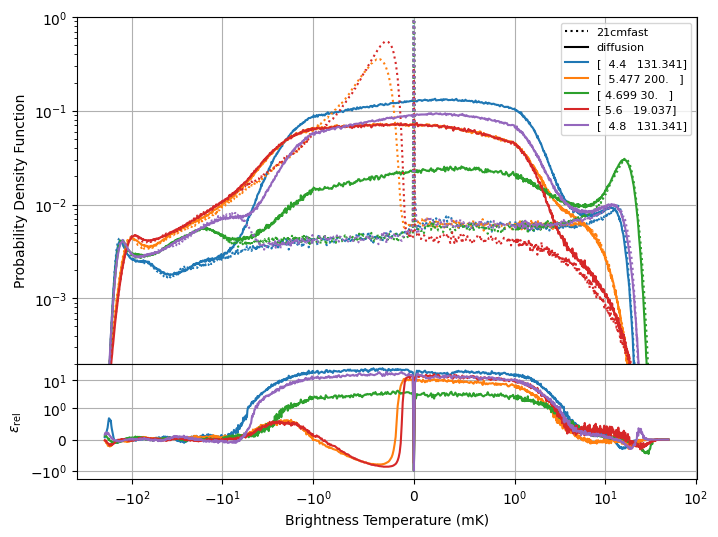

⚠️ plot_vtasked_Tb: samples.shape = (20, 1, 64, 1024)
Image saved to Tbs_44099514_ema0.pdf


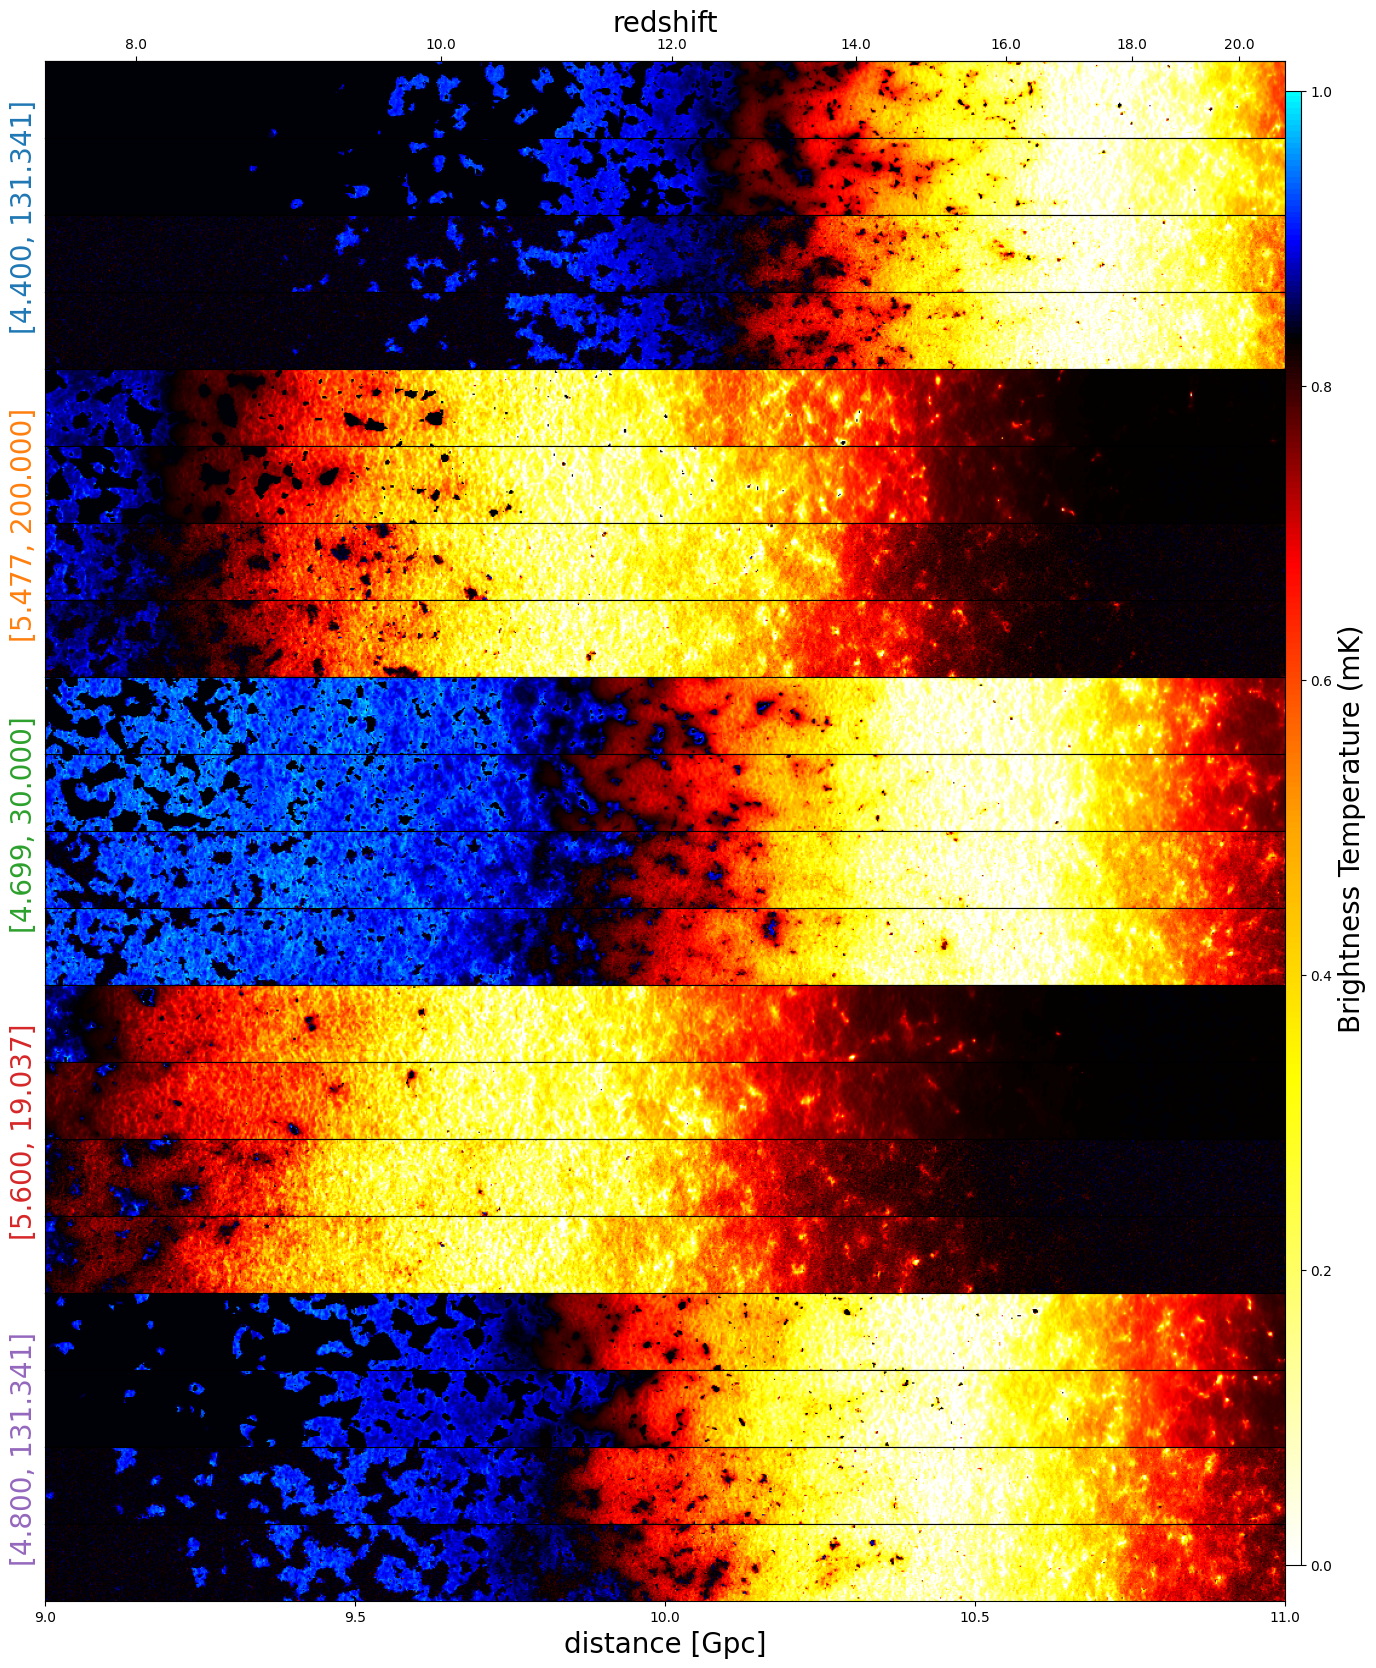

/tmp/ipykernel_2124597/4283577690.py:26: RuntimeWarning: divide by zero encountered in divide
  ax[1].plot(los[1,:Tb0_perc.shape[-1]][abs(y0)>y_eps], ((y1-y0)/abs(y0))[abs(y0)>y_eps], label=f'{np.array(params[i])}', c=f"C{i}", lw=lw)
/tmp/ipykernel_2124597/4283577690.py:26: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  ax[1].plot(los[1,:Tb0_perc.shape[-1]][abs(y0)>y_eps], ((y1-y0)/abs(y0))[abs(y0)>y_eps], label=f'{np.array(params[i])}', c=f"C{i}", lw=lw)
/tmp/ipykernel_2124597/4283577690.py:30: RuntimeWarning: divide by zero encountered in divide
  ax[2].plot(los[1,:Tb0_perc.shape[-1]][sigma0>1.5*y_eps], ((y1-y0)/sigma0)[sigma0>1.5*y_eps], label=f'{np.array(params[i])}', c=f"C{i}", lw=lw)
/tmp/ipykernel_2124597/4283577690.py:30: 

Image saved to global_Tb_44099514_ema0.pdf
x2Pk, x.shape = torch.Size([80, 1, 64, 1024])
x2Pk, x.shape = torch.Size([80, 1, 64, 1024])
x2Pk, x.shape = torch.Size([80, 1, 64, 1024])


/tmp/ipykernel_2124597/3502195001.py:22: RuntimeWarning: divide by zero encountered in divide
  ax[1].plot(k_vals, (y1-y0)/y0, label=f'{np.array(params[i])}', c=f"C{i}")
/tmp/ipykernel_2124597/3502195001.py:22: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  ax[1].plot(k_vals, (y1-y0)/y0, label=f'{np.array(params[i])}', c=f"C{i}")
/tmp/ipykernel_2124597/3502195001.py:29: RuntimeWarning: divide by zero encountered in divide
  ax[2].plot(k_vals, (y1-y0)/sigma0, label=f'{np.array(params[i])}', c=f"C{i}")
/tmp/ipykernel_2124597/3502195001.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the m

x2Pk, x.shape = torch.Size([80, 1, 64, 1024])
x2Pk, x.shape = torch.Size([80, 1, 64, 1024])
x2Pk, x.shape = torch.Size([80, 1, 64, 1024])
x2Pk, x.shape = torch.Size([80, 1, 64, 1024])
x2Pk, x.shape = torch.Size([80, 1, 64, 1024])
x2Pk, x.shape = torch.Size([80, 1, 64, 1024])
x2Pk, x.shape = torch.Size([80, 1, 64, 1024])
Image saved to power_spectrum_44099514_ema0_0.pdf


/tmp/ipykernel_2124597/3546985404.py:159: RuntimeWarning: divide by zero encountered in log10
  S2 = np.log10(S2)
/global/homes/b/binxia/.conda/envs/fsdp/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/tmp/ipykernel_2124597/3546985404.py:179: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(np.arange(y0.shape[0]), ((y1-y0)/y0), label=f'{np.array(params[i])}', c=f"C{i}")
/tmp/ipykernel_2124597/3546985404.py:179: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  ax[1].plot(np.arange(y0.shape[0]), ((y1-y0)/y0), label=f'{np.array(params[i])}', c=f"C{i}")
/tmp/ipykernel_2124597/3546985404.py:183: DeprecationWarning: __arr

Image saved to scattering_coefficients_44099514_ema0_0.pdf


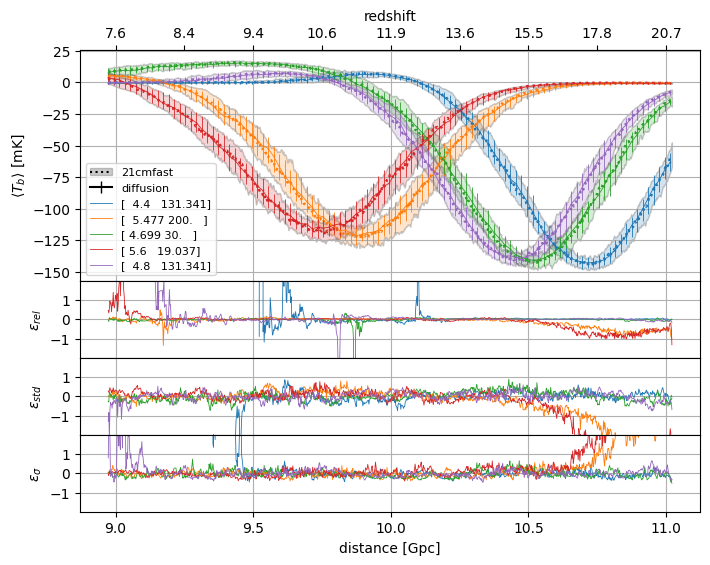

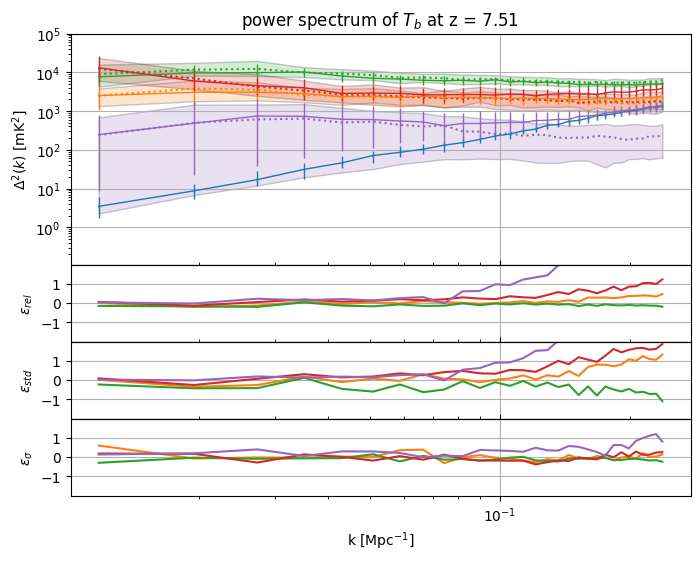

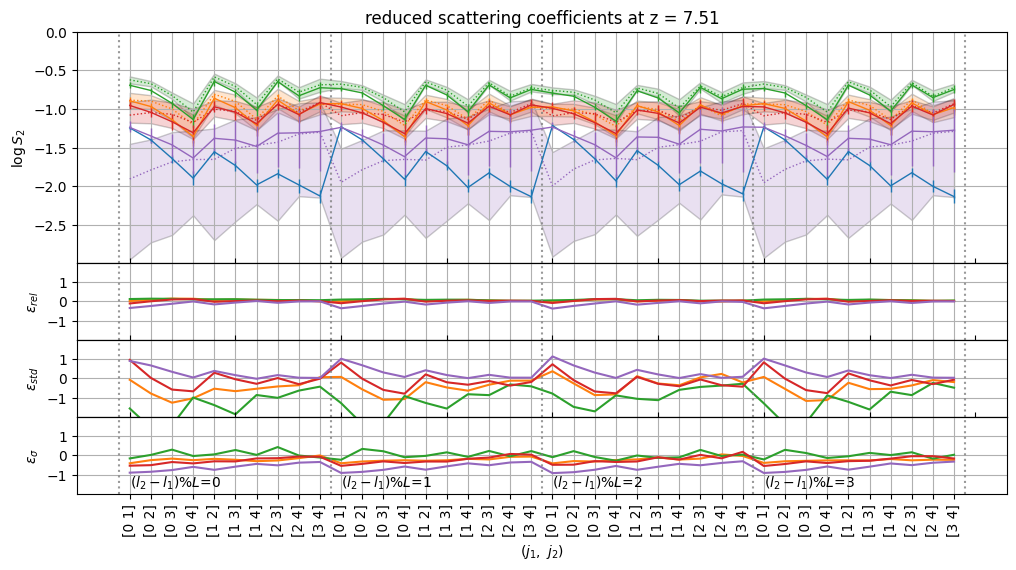

In [258]:
if __name__ == '__main__':
    sys.argv = ['notebook', '-j', '44099514', '-z', '1', '-t', 'ml']

    parser = argparse.ArgumentParser()
    parser.add_argument("-j", "--jobID", type=int, required=True)
    parser.add_argument("-z", "--z_step", type=int, default=1)
    parser.add_argument("-t", "--transform", type=str, default='ml', choices=['ml', 'sim'])
    args = parser.parse_args()

    evaluate(
            what2plot = ['stack_Tb', 'global_signal', 'power_spectrum', 'scatter_transform'],
            # device_count = 4,
            # node = 10,
            jobID = args.jobID,
            # epoch = 120,
            use_ema = 0,
            z_step = args.z_step,
            transform = args.transform if 'transform' in args else 'ml',
            )